In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, ActivityRegularization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist, mnist
import tensorflow as tf
from datetime import datetime

In [38]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [39]:
!python --version

Python 3.10.8


In [ ]:
%load_ext tensorboard

import tensorboard
tensorboard.__version__

# Clear any logs from previous runs
!rm -rf ./logs/

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

An autoencoder is a specialized artificial neural network designed to learn efficient representations of data. Unlike traditional models that output the same values given in the input, autoencoders are crafted to capture the most essential features of the input while transforming it into a compressed representation. To achieve this, hidden layers are added to the network, preventing it from merely copying and pasting the input.
An autoencoder consists of two main parts: an encoder and a decoder.

- **Encoder:**  
The encoder takes an input veor $x$ and maps it to a lower-dimensional representation $h$ using an affine transformation and an activation function:
$$h(x) = f(W_{e}\cdot x + b_{e}),$$
where $W_{e}$ is the weight matrix of the encoder, $b_{e}$ is the bias vector and $f$ is an activation function.
- **Decoder:**  
The decoder takes the encoded representation $h$ and maps it back to the original input space using another affine transformation and an activation function:
$$\hat{x} = g(h(x)) = g(W_{d}\cdot h(x) + b_{d}),$$
where $W_{d}$ is the weight matrix of the decoder and $g$ is an activation function of the decoder.  
After training, the encoder can be used to obtain a compressed representation $h$ of the input data. This compressed representation can be considered as a set of learned features capturing the most important information in the data. The autoencoders will, therefore, reconstruct the input from a latent representation.
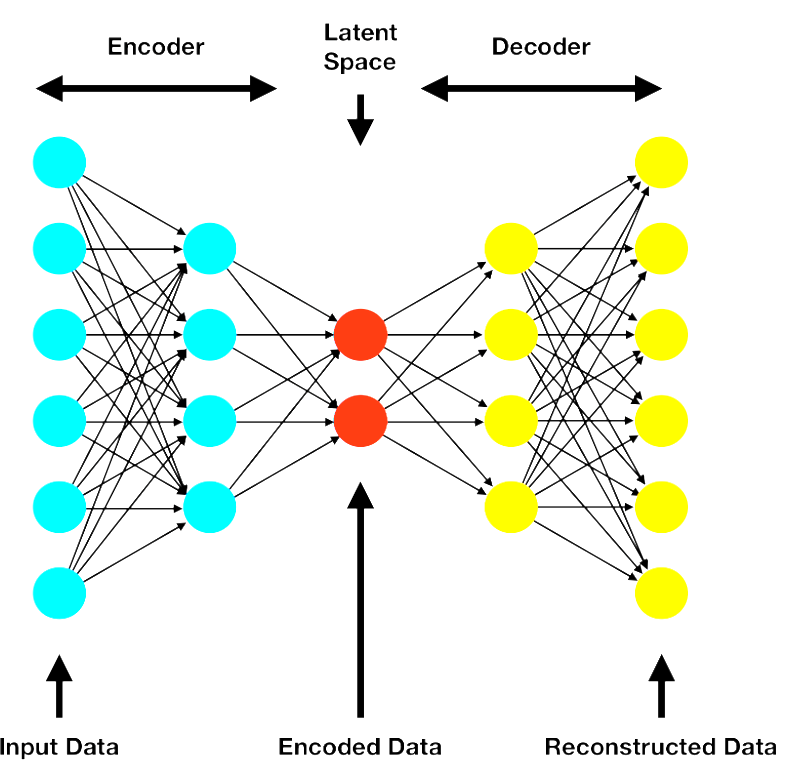

###  1. Autoencoder for dimensionality reduction

As autoencoder generates latent representations, a great application is to use such a representation with a dimension smaller than that of the input, which can then be used with a dimensionality reduction algorithm. Let's see how this can be done, using the Fashion Minist database as input.
1. Start by importing the Fashion MNIST dataset and performing necessary preprocessing. Each image has a 28x28 format, totaling 784 pixels.s;
2. The next step involves constructing an autoencoder that generates a 64-pixel latent representation.
3. Train the model using the Adam optimizer to efficiently learn essential features from the dataset.
4. Using a model with the output as the last layer of the encoder, make predictions on the test dataset, obtaining the latent representations;
5. The latent representation is then employed as input for a classification algorithm, such as XGBoost. Evaluate the results to measure the effectiveness of this approach..


In [40]:
# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

start_time = datetime.now()
# Define the autoencoder model
input_dim = x_train.shape[1]
input_img = Input(shape=(input_dim,))  # 28x28 = 784 pixels
encoded = Dense(128, activation='relu')(input_img)  # Reduce to 128 dimensions
encoded = Dense(64, activation='relu')(encoded)  # Reduce to 128 dimensions
decoded = Dense(128, activation='sigmoid')(encoded)  # Reconstruct the original input
decoded = Dense(784, activation='sigmoid')(decoded)  # Reconstruct the original input

autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=512, shuffle=True, validation_data=(x_test, x_test), callbacks=[tensorboard_callback])

Epoch 1/10
118/118 [==============================] - 1s 5ms/step - loss: 0.4657 - val_loss: 0.4013
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3800 - val_loss: 0.3613
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3472 - val_loss: 0.3394
Epoch 4/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3313 - val_loss: 0.3282
Epoch 5/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3236 - val_loss: 0.3222
Epoch 6/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3180 - val_loss: 0.3177
Epoch 7/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3139 - val_loss: 0.3142
Epoch 8/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3103 - val_loss: 0.3112
Epoch 9/10
118/118 [==============================] - 1s 4ms/step - loss: 0.3072 - val_loss: 0.3079
Epoch 10/10
118/118 [==============================] - 0s 4ms/step - loss: 0.3048 - val_loss: 0.3055

In [41]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 784)               101136    
                                                                 
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In the figure below, we see the latent representations of the example images. The output was well reconstructed when compared to the input, except for some details.

313/313 [==============================] - 0s 838us/step


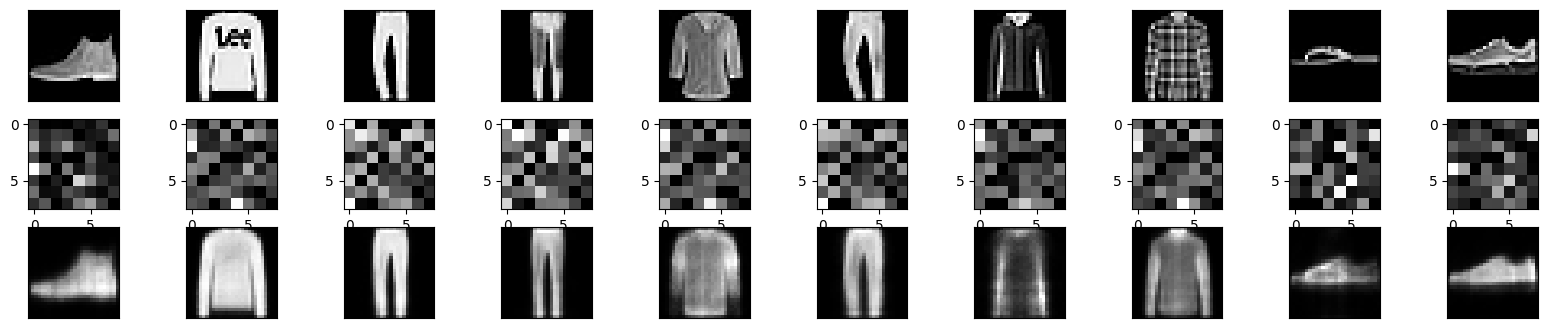

In [33]:
# Use the encoder for dimensionality reduction
encoder = Model(input_img, encoded)
encoded_data = encoder.predict(x_test)

decoder = Model(input_img, decoded)
decoded_data = decoder.predict(x_test)

# Plot original and reduced data
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(n):
    fax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_data[i].reshape(8, 8))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Decoded representation
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_data[i].reshape(28, 28))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Load the encoded MNIST dataset
encoded_x_train = encoder.predict(x_train)
encoded_x_test = encoder.predict(x_test)

# Define and train the XGBoost classifier
clf = xgb.XGBClassifier(tree_method="gpu_hist")
clf.fit(encoded_x_train, y_train)  # Assuming you have 'y_train' containing the labels

# Make predictions on the test set
y_pred = clf.predict(encoded_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

313/313 [==============================] - 0s 733us/step
Accuracy: 83.98%
Duration: 0:00:14.279990


#### classification with PCA

In [21]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import xgboost as xgb

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

start_time = datetime.now()
# Apply PCA for dimensionality reduction
n_components = 64  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Train an XGBoost classifier
clf = xgb.XGBClassifier(tree_method="gpu_hist")
clf.fit(x_train_pca, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy: 87.49%
Duration: 0:00:05.726530


#### classification without dimensionality reduction

In [22]:
# Train an XGBoost classifier
start_time = datetime.now()
clf = xgb.XGBClassifier(tree_method="gpu_hist")
clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy: 89.47%
Duration: 0:00:20.939345


When we compare with a classification without using dimensionality reduction, despite the loss of accuracy, we can obtain a better time when using the latent representations of an autoencoder. The best accuracy depends on how many epochs and the size of the latent representation used, which must be considered when using the model.
When comparing PCA and autoencoder performance on this dataset, PCA demonstrates better accuracy and efficiency. However, certain considerations arise when contemplating the use of autoencoders instead of PCA:

1. **Richer and More Complex Representations:**  
 Autoencoders: Excel at learning richer and more complex representations, especially in high-dimensional data or when facing nonlinear underlying structures.  
 PCA: Primarily captures the main directions of variance in data, making it less effective in capturing intricate representations.

2. **Dataset Size:**  
 Autoencoders: Exhibit superior performance on larger datasets, particularly when dealing with complex nonlinear patterns.  
 PCA: Proves to be more efficient and faster on smaller datasets.

3. **Interpretability:**  
 PCA: Principal components offer straightforward interpretability, representing the directions of maximum variance in the data.  
 Autoencoders: Latent representations can be more challenging to interpret, especially in more intricate architectures.

4. **Computational Complexity:**  
 Autoencoders: Can incur higher computational intensity, especially in deep architectures.  
 PCA: Boasts an efficient analytical solution, rendering it computationally more efficient.
 
 
  While PCA excels in accuracy and computational efficiency, autoencoders become particularly valuable when aiming for richer, nonlinear representations on larger datasets. Furthemore, when an autoencoder has a single layer with linear activation functions, and the training objective is to minimize the squared reconstruction error, it's equivalent to performing a linear transformation similar to PCA.

### Sparse autoencoder to feature selection

Various autoencoder variations have been developed to extract compelling latent representations from inputs by selectively deactivating the majority of neurons in the hidden layer. This strategy encourages the autoencoder to activate only a subset of neurons, effectively curating a smaller set of meaningful features from the input data. Introducing a dropout layer in the input or hidden layers of an autoencoder is a beneficial approach. This involves randomly setting a fraction of input units to zero during each update in training, mitigating overfitting by introducing a controlled form of noise and enhancing the network's robustness.

Sparse autoencoders offer another avenue. In this context, "sparse" implies that most neurons in the hidden layer (latent representation) remain inactive, contributing minimally to the overall encoding process. The sparsity constraint within a sparse autoencoder guides the model to selectively activate only a subset of neurons, effectively cherry-picking a smaller set of meaningful features from the input data. Combining dropout with sparsity constraints in autoencoders is a common practice to achieve a more robust and sparse representation. The inherent sparsity constraint in a sparse autoencoder (because it applies L1 regularization) naturally induces a form of feature selection, making it a powerful tool for learning compact and meaningful representations.

A simple L1 regularizer term could be applied, but we want to control the level of sparsity  the way we want. This can be achieved using KL Divergence, a measure of how one probability distribution diverges from a second, expected probability distribution. In the context of sparsity regularization in autoencoders, KL Divergence is used to encourage a specific distribution of activations in the latent space.

Let's see the math. The KL Divergence between two probability distributions $P(x)$ and $Q(x)$ is defined as:
$$D_{KL}(P||Q)=\sum P(x)log\frac{P(x)}{Q(x)},$$
where $P(x)$ represents the target distribution, which could be a desired level of sparsity in the latent representation (e.g., a sparse distribution with mostly zeros) and $Q(x)$ represents the actual distribution of activations in the encoding layer, specifically the mean activation.
Let $encoded_{mean}$ be the mean activation of each neuron in the encoding layer and $p$ the sparsity target. The KL Divergence term used for regularization in a sparse autoencoder might look like this:
$$D_{KL} = p\cdot log  \left (\frac{p}{encoded_{mean}}\right)+(1-p)\cdot log  \left (\frac{1 - p}{1- encoded_{mean}}\right )$$
This term measures the difference between the target sparsity distribution ($P(x)$) and the actual distribution ($(Q(x)$).

Using the formula above, let's create a customized regularizer class, KLDivergenceRegularizer. In the code, a little modification was added, creating a regularization strength parameter that multiplies the final sum.

In [14]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, beta, p=.1):
        self.beta = beta # Regularization strength (adjust as needed)
        self.p = p # Sparsity target (adjust as needed)
        
    def regularizer(self, weight_matrix):
        encoded_mean = tf.reduce_mean(weight_matrix, axis=0)
        kl_divergence = self.p * tf.math.log(self.p / encoded_mean) + (1 - self.p) * tf.math.log((1 - self.p) / (1 - encoded_mean))
        return self.beta * tf.reduce_sum(kl_divergence) 

Now, we only need to setting the regularization strength ($\beta$) and the Sparsity target parameters ($p$).

In [17]:
# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

start_time = datetime.now()
# Define the autoencoder model
kl_divergence_regularizer = KLDivergenceRegularizer(beta = 3, p=0.15).regularizer
input_img = Input(shape=(784,))  # 28x28 = 784 pixels
encoded = Dense(128, activation='relu')(input_img)  # Reduce to 128 dimensions
encoded = Dense(784, activation='sigmoid', activity_regularizer= kl_divergence_regularizer)(encoded)
decoded = Dense(128, activation='relu')(encoded)  # Reconstruct the original input
decoded = Dense(784, activation='sigmoid')(decoded)  # Reconstruct the original input


autoencoder = Model(input_img, decoded)

# Compile the model
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_5 (Dense)             (None, 128)               100480    
                                                                 
 dense_6 (Dense)             (None, 784)               101136    
                                                                 
 dense_7 (Dense)             (None, 128)               100480    
                                                                 
 dense_8 (Dense)             (None, 784)               101136    
                                                                 
Total params: 403,232
Trainable params: 403,232
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=512, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
118/118 [==============================] - 1s 6ms/step - loss: 0.5709 - val_loss: 0.4080
Epoch 2/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3791 - val_loss: 0.3591
Epoch 3/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3434 - val_loss: 0.3323
Epoch 4/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3206 - val_loss: 0.3195
Epoch 5/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3123 - val_loss: 0.3152
Epoch 6/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3081 - val_loss: 0.3108
Epoch 7/50
118/118 [==============================] - 1s 5ms/step - loss: 0.3043 - val_loss: 0.3073
Epoch 8/50
118/118 [==============================] - 1s 4ms/step - loss: 0.3016 - val_loss: 0.3058
Epoch 9/50
118/118 [==============================] - 1s 5ms/step - loss: 0.2987 - val_loss: 0.3051
Epoch 10/50
118/118 [==============================] - 1s 5ms/step - loss: 0.2975 - val_loss: 0.3024

313/313 [==============================] - 0s 895us/step


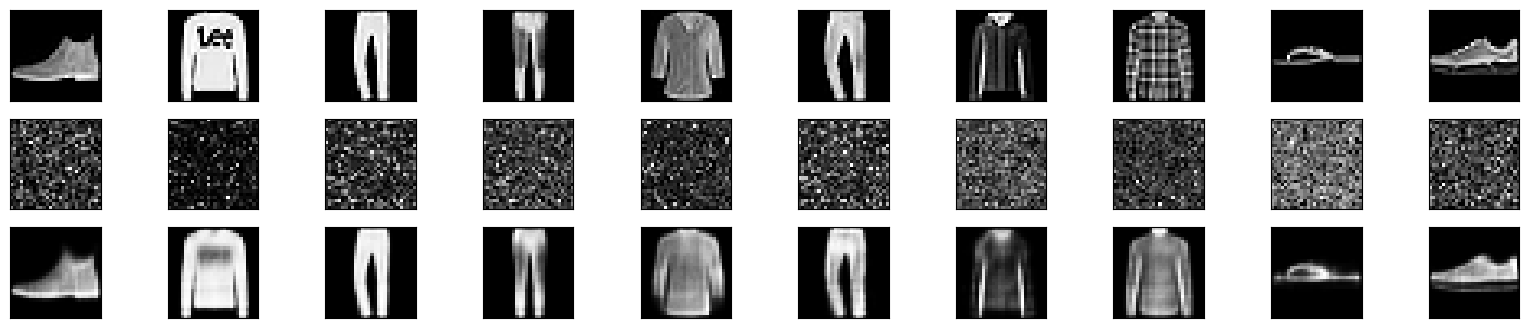

In [20]:
# Use the encoder for dimensionality reduction
encoder = Model(input_img, encoded)
encoded_data = encoder.predict(x_test)

decoder = Model(input_img, decoded)
decoded_data = decoder.predict(x_test)

# Plot original and reduced data
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reduced representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_data[i].reshape(28, 28))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Decoded representation
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_data[i].reshape(28, 28))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Load the encoded MNIST dataset
sparse_x_train = encoder.predict(x_train)
sparse_x_test = encoder.predict(x_test)

313/313 [==============================] - 0s 760us/step


In [22]:
sparse_x_train[sparse_x_train<.3]=0
sparse_x_test[sparse_x_test<.3]=0

In average, the sparsity level of the train images are close to the $1-p$ value that we defined earlier.

In [23]:
sparsity = 1.0 - (np.count_nonzero(sparse_x_train) / float(sparse_x_train.size) )
print("Sparsity: {:.2f}%".format(sparsity * 100))

Sparsity: 86.42%


In [24]:
sparsity = 1.0 - (np.count_nonzero(x_train) / float(x_train.size) )
print("Sparsity: {:.2f}%".format(sparsity * 100))

Sparsity: 50.21%


An interesting application is when we want sparsity in the training data of an ML model. Now we can convert the input to a CSR matrix and use Xgboost to train using sparse data as input.

In [25]:
from scipy import sparse
sparse_x_train = sparse.csr_matrix(sparse_x_train)
sparse_x_test = sparse.csr_matrix(sparse_x_test)

start_time = datetime.now()
# Define and train the XGBoost classifier
clf = xgb.XGBClassifier(tree_method="gpu_hist")
clf.fit(sparse_x_train, y_train)  # Assuming you have 'y_train' containing the labels

# Make predictions on the test set
y_pred = clf.predict(sparse_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy: 86.07%
Duration: 0:00:13.349363


### Denoising with Sparse Autoencoder

Another interest application is to use sparse autoencoders to denoise corrupted data. let's take advantage of the trained autoencoder on clean data early and using it to predict corrupted data. This is a valid and common approach.

313/313 [==============================] - 0s 983us/step


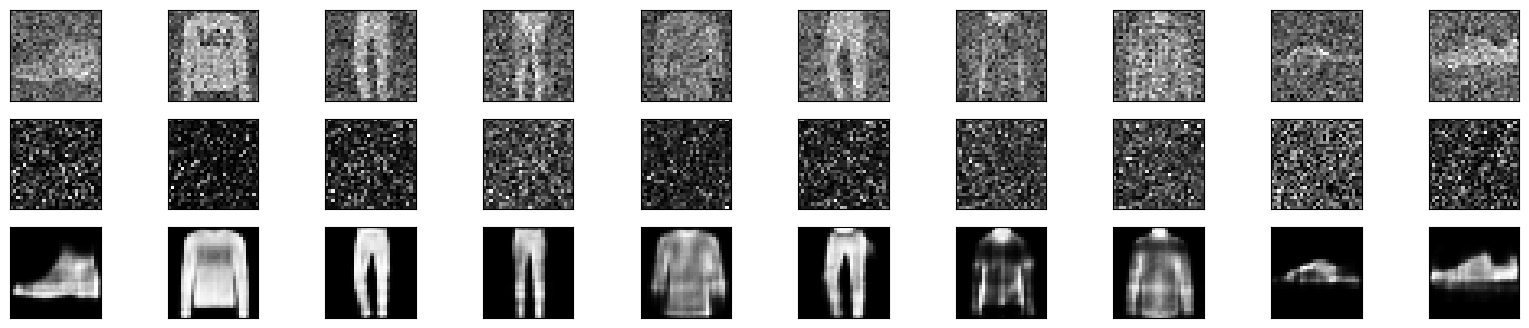

In [14]:
# Use the encoder for dimensionality reduction
noise_factor= 0.3
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

encoder = Model(input_img, encoded)
encoded_data = encoder.predict(x_test_noisy)

decoder = Model(input_img, decoded)
decoded_data = decoder.predict(x_test_noisy)

# Plot original and reduced data
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reduced representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_data[i].reshape(28, 28))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Decoded representation
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_data[i].reshape(28, 28))  # Display reduced representation
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see how the images were restored close to the original images.

### Anomaly detection

An interesting application of the use of autoencoder is in the detection of anomalies. The underlying concept is quite straightforward: for example, suppose we have a set of images of dogs and we want to identify if a different animal appears, for example, cats. We can employ autoencoders to perform the encoding of these images. It is necessary to train the network to perform both encoding and decoding. Suppose the network is trained exclusively to encode and decode images of dogs. However, if the intention is to encode and decode images of cats, it is reasonable to expect the model's performance to be suboptimal. By implementing an error threshold, it is possible to classify images based on the magnitude of the associated error, classifying those with small errors as belonging to the dog category and those with significant errors as belonging to the cat category.

In the following code, we train an autoencoder to encode and decode only images from the fashion_mnist database. We will use images from the mnist base as anomalies

In [43]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dense, BatchNormalization #layers of autoencoder
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping #callbacks
from tensorflow.keras import regularizers #regularization
import seaborn as sns
from sklearn.metrics import classification_report

In [44]:
# Load and preprocess the dataset
def preprocessing_mnist(input_data):
    x_train = input_data[0][0]
    y_train = input_data[0][1]
    x_test = input_data[1][0]
    y_test = input_data[1][1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    return (x_train, y_train), (x_test, y_test)

(x_train_normal, y_train_normal), (x_test_normal, y_test_normal) = preprocessing_mnist(fashion_mnist.load_data())
(x_train_fraud, y_train_fraud), (x_test_fraud, y_test_fraud) = preprocessing_mnist(mnist.load_data())

In [45]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the encoding dimension
encoding_dim = 256

# Define the encoder layers
input_dim = x_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(units=encoding_dim, activation='tanh', use_bias=False)(input_layer)
encoder = Dense(units=int(encoding_dim/2), activation='selu')(encoder)
encoder = Dense(units=int(encoding_dim/4), activation='selu')(encoder)

# Define the decoder layers
decoder = Dense(units=int(encoding_dim/2), activation='selu')(encoder)
decoder = Dense(units=encoding_dim, activation='selu')(decoder)
decoder = Dense(units=input_dim, activation='selu')(decoder)

# Create the autoencoder model and encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Set training parameters
epochs = 200
batch_size = 512

# Define callbacks for early stopping and model checkpoint
best_weights_filepath = './best_weights.hdf5'
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')
save_best_model = ModelCheckpoint(best_weights_filepath, monitor='val_loss', 
                                  verbose=1, save_best_only=True, mode='auto')

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the autoencoder
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=epochs, batch_size=batch_size, shuffle=False,
                          validation_split=0.2, verbose=1,
                          callbacks=[save_best_model, early_stopping]).history

# Load the best weights obtained during training
autoencoder.load_weights(best_weights_filepath)


Epoch 1/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0800 - accuracy: 0.0055
Epoch 1: val_loss improved from inf to 0.03422, saving model to .\best_weights.hdf5
94/94 [==============================] - 1s 8ms/step - loss: 0.0763 - accuracy: 0.0057 - val_loss: 0.0342 - val_accuracy: 0.0086
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.0100
Epoch 2: val_loss improved from 0.03422 to 0.02615, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0293 - accuracy: 0.0100 - val_loss: 0.0262 - val_accuracy: 0.0119
Epoch 3/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0246 - accuracy: 0.0129
Epoch 3: val_loss improved from 0.02615 to 0.02294, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0245 - accuracy: 0.0130 - val_loss: 0.0229 - val_accuracy: 0.0107
Epoch 4/200
83/94 [=========================>....] - ETA: 0s - loss:

Epoch 28/200
88/94 [===========================>..] - ETA: 0s - loss: 0.0119 - accuracy: 0.0320
Epoch 28: val_loss improved from 0.01196 to 0.01185, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0119 - accuracy: 0.0322 - val_loss: 0.0118 - val_accuracy: 0.0288
Epoch 29/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.0321
Epoch 29: val_loss did not improve from 0.01185
94/94 [==============================] - 0s 5ms/step - loss: 0.0119 - accuracy: 0.0322 - val_loss: 0.0132 - val_accuracy: 0.0292
Epoch 30/200
84/94 [=========================>....] - ETA: 0s - loss: 0.0119 - accuracy: 0.0326
Epoch 30: val_loss did not improve from 0.01185
94/94 [==============================] - 0s 5ms/step - loss: 0.0119 - accuracy: 0.0329 - val_loss: 0.0122 - val_accuracy: 0.0278
Epoch 31/200
85/94 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.0321
Epoch 31: val_loss improved from 0.01185 to 

Epoch 56/200
88/94 [===========================>..] - ETA: 0s - loss: 0.0106 - accuracy: 0.0371
Epoch 56: val_loss improved from 0.01058 to 0.01057, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0106 - accuracy: 0.0369 - val_loss: 0.0106 - val_accuracy: 0.0354
Epoch 57/200
93/94 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.0377
Epoch 57: val_loss did not improve from 0.01057
94/94 [==============================] - 0s 5ms/step - loss: 0.0104 - accuracy: 0.0376 - val_loss: 0.0106 - val_accuracy: 0.0369
Epoch 58/200
81/94 [========================>.....] - ETA: 0s - loss: 0.0105 - accuracy: 0.0363
Epoch 58: val_loss improved from 0.01057 to 0.01036, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0105 - accuracy: 0.0368 - val_loss: 0.0104 - val_accuracy: 0.0356
Epoch 59/200
81/94 [========================>.....] - ETA: 0s - loss: 0.0104 - accuracy: 0.0368
Epo

83/94 [=========================>....] - ETA: 0s - loss: 0.0098 - accuracy: 0.0397
Epoch 84: val_loss did not improve from 0.00980
94/94 [==============================] - 1s 5ms/step - loss: 0.0100 - accuracy: 0.0398 - val_loss: 0.0108 - val_accuracy: 0.0356
Epoch 85/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0099 - accuracy: 0.0396
Epoch 85: val_loss did not improve from 0.00980
94/94 [==============================] - 0s 5ms/step - loss: 0.0099 - accuracy: 0.0399 - val_loss: 0.0099 - val_accuracy: 0.0381
Epoch 86/200
84/94 [=========================>....] - ETA: 0s - loss: 0.0098 - accuracy: 0.0402
Epoch 86: val_loss improved from 0.00980 to 0.00974, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0097 - accuracy: 0.0408 - val_loss: 0.0097 - val_accuracy: 0.0375
Epoch 87/200
82/94 [=========================>....] - ETA: 0s - loss: 0.0099 - accuracy: 0.0405
Epoch 87: val_loss did not improve from 0.00974
94/94 [==

94/94 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 0.0428 - val_loss: 0.0095 - val_accuracy: 0.0418
Epoch 113/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0093 - accuracy: 0.0434
Epoch 113: val_loss improved from 0.00940 to 0.00939, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0093 - accuracy: 0.0434 - val_loss: 0.0094 - val_accuracy: 0.0419
Epoch 114/200
85/94 [==========================>...] - ETA: 0s - loss: 0.0094 - accuracy: 0.0436
Epoch 114: val_loss improved from 0.00939 to 0.00939, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 0.0437 - val_loss: 0.0094 - val_accuracy: 0.0422
Epoch 115/200
91/94 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.0431
Epoch 115: val_loss did not improve from 0.00939
94/94 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 0.0430 - val_

Epoch 141/200
83/94 [=========================>....] - ETA: 0s - loss: 0.0092 - accuracy: 0.0445
Epoch 141: val_loss did not improve from 0.00918
94/94 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.0448 - val_loss: 0.0094 - val_accuracy: 0.0431
Epoch 142/200
85/94 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.0444
Epoch 142: val_loss did not improve from 0.00918
94/94 [==============================] - 0s 5ms/step - loss: 0.0091 - accuracy: 0.0444 - val_loss: 0.0092 - val_accuracy: 0.0438
Epoch 143/200
87/94 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.0445
Epoch 143: val_loss improved from 0.00918 to 0.00908, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 0.0446 - val_loss: 0.0091 - val_accuracy: 0.0442
Epoch 144/200
85/94 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.0449
Epoch 144: val_loss did not improve f

85/94 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.0471
Epoch 170: val_loss improved from 0.00892 to 0.00892, saving model to .\best_weights.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 0.0088 - accuracy: 0.0470 - val_loss: 0.0089 - val_accuracy: 0.0442
Epoch 171/200
84/94 [=========================>....] - ETA: 0s - loss: 0.0089 - accuracy: 0.0468
Epoch 171: val_loss did not improve from 0.00892
94/94 [==============================] - 0s 5ms/step - loss: 0.0089 - accuracy: 0.0469 - val_loss: 0.0092 - val_accuracy: 0.0428
Epoch 172/200
82/94 [=========================>....] - ETA: 0s - loss: 0.0088 - accuracy: 0.0465
Epoch 172: val_loss did not improve from 0.00892
94/94 [==============================] - 0s 5ms/step - loss: 0.0089 - accuracy: 0.0469 - val_loss: 0.0093 - val_accuracy: 0.0452
Epoch 173/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.0463
Epoch 173: val_loss did not improve from 0.00892
94

93/94 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.0483
Epoch 199: val_loss did not improve from 0.00874
94/94 [==============================] - 0s 5ms/step - loss: 0.0087 - accuracy: 0.0483 - val_loss: 0.0088 - val_accuracy: 0.0453
Epoch 200/200
86/94 [==========================>...] - ETA: 0s - loss: 0.0088 - accuracy: 0.0471
Epoch 200: val_loss did not improve from 0.00874
94/94 [==============================] - 0s 5ms/step - loss: 0.0088 - accuracy: 0.0474 - val_loss: 0.0089 - val_accuracy: 0.0465


In [46]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_13 (Dense)            (None, 256)               200704    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 784)               2014

Now, we evaluate the autoencoder on both normal and fraudulent data and calculate the mean squared error (MSE) for each sample.

In [ ]:
x_pred_normal = autoencoder.predict(x_test_normal)
x_pred_fraud = autoencoder.predict(x_test_fraud)

# Calculate the mean squared error (MSE) for each sample
mse_normal = np.mean(np.square(x_test_normal - x_pred_normal), axis=1)
mse_fraud = np.mean(np.square(x_test_fraud - x_pred_fraud), axis=1)

Set a threshold for anomaly detection (e.g., based on quantiles or domain knowledge) and Identify anomalies based on the threshold for both normal and fraudulent data.

In [ ]:
threshold = np.percentile(mse_normal, 90)  # Example threshold (95th percentile)

fp = x_test_normal[mse_normal > threshold]
tp = x_test_fraud[mse_fraud > threshold]
tn = x_test_normal[mse_normal < threshold]
fn = x_test_fraud[mse_fraud < threshold]

visualizing the confusion matrix, We can note that only 0.55% of frauds were classified as normal data and only 5% of normal data identified as frauds.

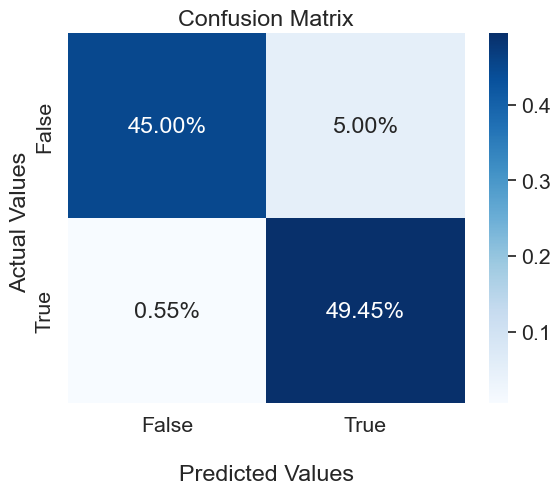

In [52]:
cf_matrix = [[len(tn), len(fp)],
         [len(fn), len(tp)]]

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Text(0.5, 1.0, 'loss in train and validation split')

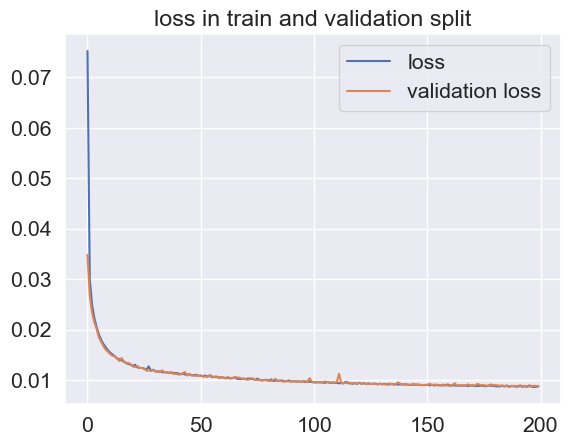

In [50]:
#plotting the history of the model\qz
plt.figure()
plt.plot(history['loss'],label='loss')
plt.legend()
plt.plot(history['val_loss'],label='validation loss')
plt.legend()
plt.title('loss in train and validation split')

We can note that only 0.55% of frauds were classified as normal data and 5% of normal data identified as frauds.

Text(0.5, 1.0, 'Reconstruction error')

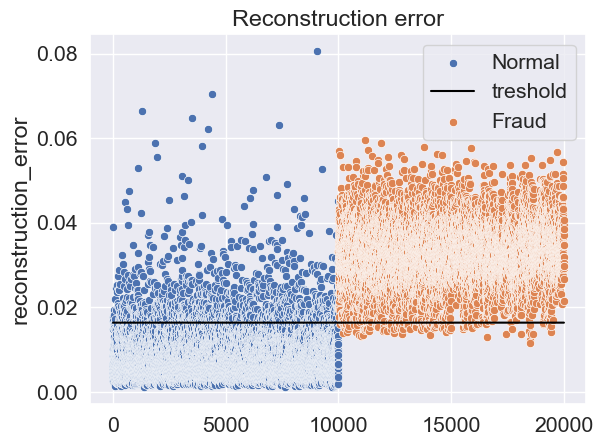

In [51]:
y_test=[0]*len(mse_normal)+[1]*len(mse_fraud)
mse= np.hstack([mse_normal, mse_fraud])
error_df=pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})
error_df = error_df.query('reconstruction_error<=100')
t0 = error_df.loc[error_df['true_class'] == 0]
t1 = error_df.loc[error_df['true_class'] == 1]
t2=threshold*np.ones((len(y_test),), dtype=int)
sns.scatterplot(data = t0['reconstruction_error'] ,label="Normal", )
sns.lineplot(data=t2, color='black', label='treshold')
sns.scatterplot(data = t1['reconstruction_error'],label="Fraud").set_title('Reconstruction error')

### AutoRec - System Recommendation

Autoencoders also can be used as a component in building a recommender system, especially in scenarios where you want to learn meaningful representations of user preferences or item characteristics. 

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess the MovieLens dataset (replace with your data)
columns = ['userId', 'movieId', 'rating', 'timestamp']
data = pd.read_csv('ml-1m/ratings.dat', sep='::', names=columns, engine='python')  # Adjust the file path

This is our initial data. Each line is a movie rated by an user who watched this movie.

In [48]:
data

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [49]:
n_users_movie = data.movieId.value_counts().reset_index()
n_users_movie['%total'] = n_users_movie.movieId/data.userId.nunique()
n_users_movie.columns = ['movieId', 'n_users', '%total']

n_movies = 100
q2 = sum(n_users_movie.n_users>=n_movies)
print(f'The number of movies  watched for more than {n_movies} users is {q2}.')
relevant_movies = list(n_users_movie[n_users_movie.n_users>=n_movies].movieId)

The number of movies  watched for more than 100 users is 2019.


In [50]:
data = data[data.movieId.isin(relevant_movies)]

In [51]:
data.userId.nunique()

6040

For the purpose of evaluating our model, we will mask 20% of the rated movies for each user.

In [52]:
from scipy import sparse
df_masked = data.groupby('userId', group_keys=False).apply(lambda x: x.sample(frac=.2))
df_unmasked = data.drop(df_masked.index)
df_unmasked = df_unmasked[df_unmasked.userId.isin(df_masked.userId.unique())]

Now, we reate a user-item interaction matrix with NaN values for missing ratings.

In [53]:
train = df_unmasked.pivot(index='userId', columns='movieId', values='rating')
test = df_masked.pivot(index='userId', columns='movieId', values='rating')

In [54]:
train

movieId,1,2,3,4,5,6,7,9,10,11,...,3928,3929,3930,3932,3936,3937,3946,3948,3949,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This user-item matrix interaction will be the input to the autoencoder. The objective is to make the neural network reconstruct the input by filling in the missing values, which will allow rating predictions for films that users have not watched yet.

As TensorFlow does not handle missing data, our approach involves converting all missing values to 0, a distinct value outside the rating range. However, a significant challenge arises in this process. When training an autoencoder with this modified input, the model tends to prioritize the faithful reconstruction of the original data, inevitably leading to predictions of zero for the missing ratings. To address this issue, a viable solution is to devise a custom loss function tailored to consider only non-null values during the training process. This approach creates a mechanism for the model to focus only on observed values and ignore imputed values. This way, the AutoRec model is encouraged to learn meaningful patterns in existing data, avoiding overprediction of imputed values as 0.

It works because autoencoders are neural networks that have the ability to learn latent representations of data. By training the autoencoder to reconstruct the item-user matrix, it is learning a compact and informative representation of the underlying patterns in the data, even with the imputation of null values.

The custom loss function can be expressed mathematically as follows:
$$MSE_{custom}(Y,\hat{Y}) = \frac{1}{n}\sum_{i,j\in \textit{O}}(Y_{ìj}-\hat{Y}_{ij})^{2},$$
where $n$ is the number of observations and $i,j\in \textit{O}$ means that $Y_{ij}$ is observed.

In [55]:
# Custom loss function that considers only observed ratings
def custom_loss(y_true, y_pred):
    mask = tf.where(y_true==0, 0.0, 1.0)
    mse = tf.reduce_mean(tf.square(mask * (y_true - y_pred)), axis=-1)
    return mse

In [56]:
# Create the AutoRec model
# Define the dimensions of the input and the size of the encoding layer
input_dim = train.shape[1]
encoding_dim = 32  # Adjust as needed
input_layer = Input(shape=(input_dim,), sparse=True)
encoded = Dense(encoding_dim, activation='selu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss=custom_loss)
    
# Train the AutoRec model on the training data
autoencoder.fit(train.fillna(0).values, train.fillna(0).values, epochs=50, batch_size=128, shuffle=False)

Epoch 1/50
48/48 [==============================] - 1s 7ms/step - loss: 0.3811
Epoch 2/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1189
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 0.0864
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0730
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0622
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0598
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0581
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 11/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 12/50
48/48 [==============================] - 0s 3ms/step - loss: 0.0539
Epoch 13/50
48/48 [==============================

In [57]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2019)]            0         
                                                                 
 dense_19 (Dense)            (None, 32)                64640     
                                                                 
 dense_20 (Dense)            (None, 2019)              66627     
                                                                 
Total params: 131,267
Trainable params: 131,267
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Extract user embeddings from the encoder layer
user_decoder = autoencoder.predict(train.fillna(0).values)

189/189 [==============================] - 0s 2ms/step


In [62]:
def rmse(x, y):
    x = np.array(x)
    y = np.array(y)
    
    if x.shape != y.shape:
        raise ValueError("Vectors must have the same shape")
    count_non_nan_x = np.sum(~np.isnan(x))
    count_non_nan_y = np.sum(~np.isnan(y))
    mse = np.sqrt(np.nanmean((x - y) ** 2))
    return mse

def avg_rmse(matrix_1, matrix_2):
    s = []
    for i,j in zip(matrix_1, matrix_2):
        s.append(rmse(i,j))
    return np.mean(s)     

Using the test dataset to evaluate our model, we can a rmse=0.9. A good result.

In [63]:
avg_rmse(test.values, user_decoder)

0.9076083996089744

## Variational Autoencoders

Generating synthetic data is a powerful approach to addressing challenges associated with limited-world datasets. When it comes to creating synthetic data, Variational Autoencoders (VAEs) play a significant role. In essence, VAEs serve as creative data architects. They learn the underlying structure of real data, capture its variability, and then use that knowledge to generate synthetic examples that preserve the essential characteristics. This process enhances data availability, facilitates model training, and contributes to the development of more robust and versatile machine learning systems.
Let's break down how Variational Autoencoders (VAEs) work step by step:


step by step:

1. **Encoder Network:**
   - **Objective:** The goal of the encoder is to map input data $x$ to a probability distribution in the latent space. This distribution is typically modeled as a multivariate Gaussian with mean ($\mu$) and log variance ($\log(\sigma^2)$).
   - **Equation:** The encoder network takes $x$ as input and outputs parameters of the latent space distribution: $$\mu, \log\sigma^2 = \text{Encoder}(x)$$.

2. **Reparameterization Trick:**
   - **Objective:** To make the backpropagation of gradients feasible through the sampling process, the reparameterization trick is employed. It involves sampling from a standard normal distribution ($\epsilon \sim \mathcal{N}(0, 1)$) and transforming it to match the parameters of the Gaussian distribution obtained from the encoder.
   - **Equation:** $$z = \mu + \sigma \odot \epsilon$$, where $\odot$ denotes element-wise multiplication.

3. **Latent Space Sampling:**
   - **Objective:** By using the reparameterization trick, the encoder produces a sample $z$ from the distribution in the latent space.
   - **Visualization:** This step can be imagined as sampling different points in a continuous space that represents various possible versions of the input data.

4. **Decoder Network:**
   - **Objective:** The decoder takes the sampled latent variable $z$ and attempts to reconstruct the original input $x$.
   - **Equation:** $$x_{\text{recon}} = \text{Decoder}(z)$$.

5. **Reconstruction Loss:**
   - **Objective:** The reconstruction loss measures how well the generated data ($x_{\text{recon}}$) matches the original input $x$.
   - **Equation:** Typically, the negative log-likelihood of the data given the latent variable is used as the reconstruction loss.

6. **KL Divergence Loss:**
   - **Objective:** The KL divergence loss ensures that the distribution of latent variables ($q(z|x)$) is close to a predefined prior distribution (often a standard normal distribution). This choice is motivated by the fact that The KL divergence term in the VAE objective acts as a regularization term. When the prior distribution is chosen to be a standard normal distribution (with mean 0 and variance 1), it encourages the learned latent space to be well-structured and spread out, promoting generalization and preventing overfitting.
   - **Equation:** $$-\frac{1}{2} \sum_{i=1}^{d} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$, where $d$ is the dimensionality of the latent space.

7. **Variational Lower Bound (ELBO):**
   - **Objective:** The ELBO is the sum of the reconstruction loss and the KL divergence loss. Maximizing the ELBO during training ensures accurate reconstruction while keeping the latent space well-behaved.
   - **Equation:** $$\text{ELBO} = \text{Reconstruction Loss} + \text{KL Divergence Loss}$$.

8. **Training:**
   - **Objective:** The model is trained by minimizing the negative ELBO. Optimization algorithms such as stochastic gradient descent are used to adjust the model parameters (encoder and decoder weights) to find the optimal configuration.
   - **Loss Function:** $$\mathcal{L} = -\text{ELBO}$$.

9. **Generation:**
   - **Objective:** Once trained, the VAE can generate new data by sampling from the latent space and passing the samples through the decoder.
   - **Visualization:** This process creates new data points that share similarities with the training data, showcasing the generative capability of the VAE.

In summary, VAEs learn to encode input data into a probabilistic representation, sample from this representation, and decode the samples to reconstruct the input. The training process involves balancing accurate reconstruction with a well-behaved latent space, achieved by optimizing the ELBO. The result is a model that can not only reconstruct input data but also generate novel, similar data.

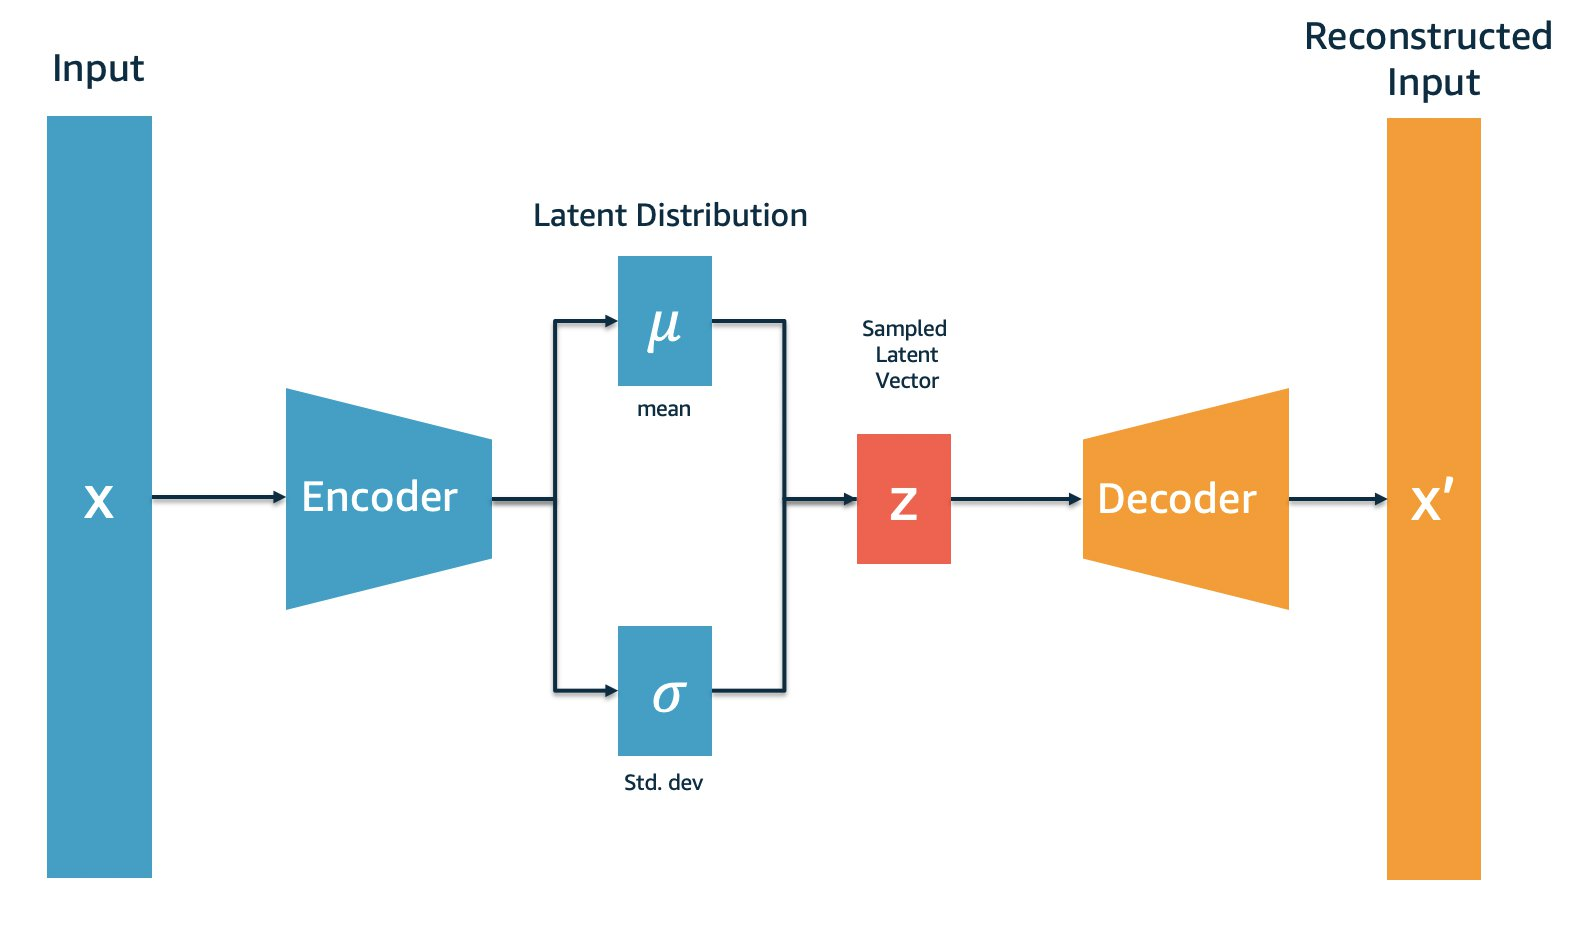

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist
from scipy.stats import norm

# Load StyleMNIST data
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Flatten and normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# VAE model architecture
def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(256, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Sampling from the latent space using the reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(256, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(inputs, x_decoded_mean)

    # Define the custom loss function for VAE
    xent_loss = input_dim * metrics.binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    # Encoder model (for generating latent variables)
    encoder = Model(inputs, z_mean)

    # Decoder model (for generating synthetic data)
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    return vae, encoder, generator

# Generate synthetic data
input_dim = 784  # Number of features in StyleMNIST
synthetic_data = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

# Build VAE model
vae, encoder, generator = build_vae(input_dim, latent_dim=2)

# Train the VAE
vae.fit(synthetic_data, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 7s 4ms/step - loss: 290.1392 - val_loss: 276.7152
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 273.6345 - val_loss: 272.5318
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 271.2879 - val_loss: 271.2827
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 269.9383 - val_loss: 270.3734
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 268.9436 - val_loss: 269.4944
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 268.1565 - val_loss: 269.0491
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 267.4847 - val_loss: 268.9236
Epoch 8/50
1500/1500 [==============================] - 6s 4ms/step - loss: 266.9062 - val_loss: 268.9023
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 266.4265 - val_loss: 267.7339
Epoch 10/50
1500/1500 [=======================

We load the StyleMNIST data using the fashion_mnist dataset from Keras, normalize the pixel values, and reshape the images for the VAE model. The VAE is trained on the StyleMNIST data, and then new synthetic images are generated and visualized alongside their original counterparts. The generated images should exhibit style variations learned by the VAE. 

4/4 [==============================] - 0s 4ms/step


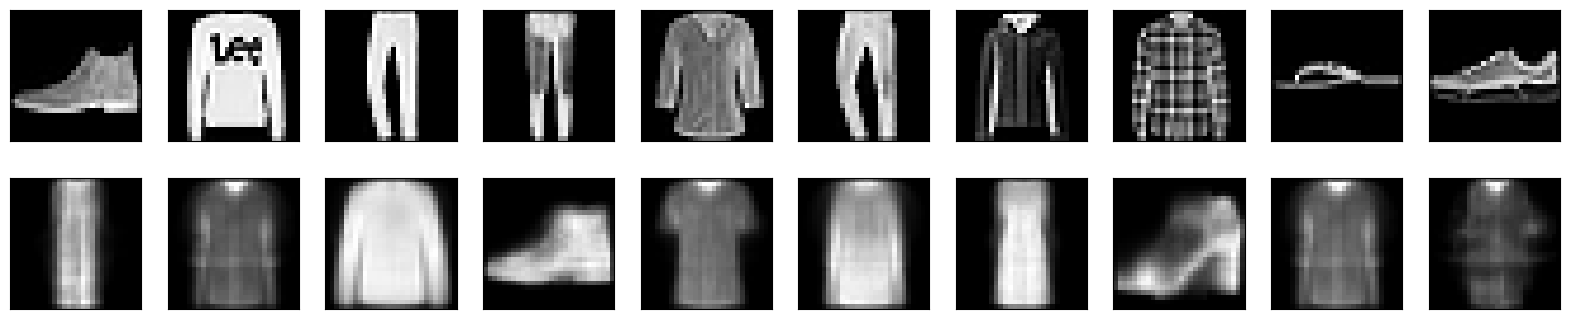

In [12]:
# Generate new synthetic data using the trained VAE
generated_data = generator.predict(np.random.normal(size=(100, 2)))

# Reshape the generated data for visualization
generated_data = generated_data.reshape((100, 28, 28))

# Plot original and generated StyleMNIST images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Generated image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In the first line we have the original generated images, while in the second we have synthetic images. The quality is certainly not original, but we can see silhouettes and colors that resemble items from the database we use as input.

In [26]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                              